# 이 파일은 15-1에 대한 실습

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


- 문장길이를 숫자로 반환 (칼럼 새로 만들어서)
  - 이를 통해 이상치 제거
  - percentile 이용
  - IQR 찾아서 weight 곱하고 (Q_3+IQR*w <= <= Q_1 - IQR * w), w=5
    - 25 ~ 75% 사이 데이터만 추출

- 경우의 수 나눠
  - spam - spam(TP), ham(FN)
  - ham - ham(FP), spam(TN)
  - 이를 통해 accuracy, precision, recall, f1 score 산출 가능
  - $accuracy = \frac{TN+TP}{TN+TP+FN+TP}$
  - $precision = \frac{TP}{FP+TP}$ 예측값이 기준: 내가 spam이라고 예측한 것 중에 맞은 개수
  - $recall = \frac{TP}{FN+TP}$ 처음값이 기준: 실제로 spam인것중에 맞은 개수
  - 우리는 precision만 가져가는걸로!

- 그래서 우리는 precision 몇%인지, spam에는 ~~단어가 있더라 결과를 내야됨

- Tfidf할떄 Scaler: MinMaxScaler
  - Tfidfvectorizer하고 spam 여부 T/F 칼럼 만들어서 T/F끼리 다 더해서 평균해줌 (T_mean, F_mean)
  - T_mean - F_mean 해주면 값 나오고 이거 행별로 matmul 시키면 점수 나옴
  - 이 점수를 MinMaxScaler로 정규화해서 [0,1]값으로


In [ ]:
import sys, os
PATH = "/content/drive/MyDrive/01. Programming/Practical NLP/"
sys.path.append(PATH)

In [ ]:
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/01. Programming/Practical NLP/']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [ ]:
FILE_PATH = "drive/MyDrive/01. Programming/Practical NLP/data/Week 15/spam-ham.csv"
df = pd.read_csv(FILE_PATH, index_col=0)
pd.set_option('display.max_colwidth', None)
df.head(3)

,spam,text
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


# 1. Text Normalization

In [ ]:
# preprocess with keras
from tensorflow.keras.preprocessing.text import text_to_word_sequence

FILE_PATH = "drive/MyDrive/01. Programming/Practical NLP/data/Week 15/spam-ham.csv"
df = pd.read_csv(FILE_PATH, index_col=0)
pd.set_option('display.max_colwidth', None)

df['text'] = [" ".join(text_to_word_sequence(i)) for i in df['text']]
df['text'] = [i.lower() for i in df['text']]
df

,spam,text
0,0,go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
1,0,ok lar joking wif u oni
2,1,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry question std txt rate t c's apply 08452810075over18's
3,0,u dun say so early hor u c already then say
4,0,nah i don't think he goes to usf he lives around here though
...,...,...
4832,1,this is the 2nd time we have tried 2 contact u u have won the £750 pound prize 2 claim is easy call 087187272008 now1 only 10p per minute bt national rate
4833,0,will ü b going to esplanade fr home
4834,0,pity was in mood for that so any other suggestions
4835,0,the guy did some bitching but i acted like i'd be interested in buying something else next week and he gave it to us for free


# 2. EDA

In [ ]:
# null value 확인 -> 없음
print(df.isna().sum())

# drop_duplicates
df = df.drop_duplicates()
df

spam    0
text    0
dtype: int64


,spam,text
0,0,go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
1,0,ok lar joking wif u oni
2,1,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry question std txt rate t c's apply 08452810075over18's
3,0,u dun say so early hor u c already then say
4,0,nah i don't think he goes to usf he lives around here though
...,...,...
4832,1,this is the 2nd time we have tried 2 contact u u have won the £750 pound prize 2 claim is easy call 087187272008 now1 only 10p per minute bt national rate
4833,0,will ü b going to esplanade fr home
4834,0,pity was in mood for that so any other suggestions
4835,0,the guy did some bitching but i acted like i'd be interested in buying something else next week and he gave it to us for free


In [ ]:
# 문장 길이에 따른 outlier 제거

df['length'] = [len(i) for i in df['text']]

def get_outlier(df, column, w=0.5):
  q_25 = np.percentile(df[column].values, 25)
  q_75 = np.percentile(df[column].values, 75)
  
  IQR = q_75 - q_25
  IQR_weight = IQR * w

  lowest, highest = q_25 - IQR_weight, q_75 + IQR_weight
  outlier_idx = df[column][(df[column] < lowest) | (df[column] > highest)].index
  return outlier_idx

outlier_idx = get_outlier(df, "length")
df = df.drop(outlier_idx, axis=0).reset_index(drop=True)
df
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,spam,text,length
0,0,go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat,102
1,0,ok lar joking wif u oni,23
2,0,u dun say so early hor u c already then say,43
3,0,nah i don't think he goes to usf he lives around here though,60
4,1,freemsg hey there darling it's been 3 week's now and no word back i'd like some fun you up for it still tb ok xxx std chgs to send £1 50 to rcv,143
...,...,...,...
4050,1,reminder from o2 to get 2 50 pounds free call credit and details of great offers pls reply 2 this text with your valid name house no and postcode,145
4051,0,will ü b going to esplanade fr home,35
4052,0,pity was in mood for that so any other suggestions,50
4053,0,the guy did some bitching but i acted like i'd be interested in buying something else next week and he gave it to us for free,125


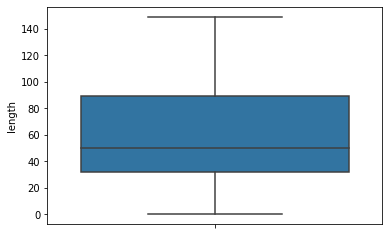

In [ ]:
# check with boxplot
sns.boxplot(y=df['length'], orient='v')

# 3. 임베딩 모델 비교: Tfidf vs PPMI

## 3.1. Tfidf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
dtm = tfidf.fit_transform(df.text).toarray()
dtm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# spam, ham => T/F
mask = df.spam.astype(bool).values
mask

array([False, False, False, ..., False, False, False])

In [ ]:
def get_spamness(df, matrix):
  mask = df.spam.astype(bool).values
  spam_avg = matrix[mask].mean(axis=0)
  ham_avg = matrix[~mask].mean(axis=0)
  spamness = matrix.dot(spam_avg - ham_avg)
  return spamness

In [ ]:
spamness = get_spamness(df, dtm)

In [ ]:
# scaling
from sklearn.preprocessing import MinMaxScaler
df['tfidf_score']=MinMaxScaler().fit_transform(spamness.reshape(-1, 1))

# .fit(), .transform() 따로 있음
df.head(3)

,spam,text,length,tfidf_score
0,0,go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat,102,0.225860
1,0,ok lar joking wif u oni,23,0.211975
3,0,u dun say so early hor u c already then say,43,0.170311


In [ ]:
df['prediction'] = (df['tfidf_score'] > 0.5).astype(int)
df.head(3)

,spam,text,length,tfidf_score,prediction
0,0,go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat,102,0.225860,0
1,0,ok lar joking wif u oni,23,0.211975,0
3,0,u dun say so early hor u c already then say,43,0.170311,0


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score
tfidf_conf = confusion_matrix(df.spam, df.prediction)
tfidf_conf

array([[3672,   31],
       [  78,  274]])

## 3.2. PPMI

In [ ]:
# from pmi import get_indexes   # ppmi not imported for tqdm
from tqdm.notebook import tqdm

def get_indexes(text):
    # text = text.lower().replace('.', ' ')
    words = text.split()
    
    word2idx = dict() # (word, idx)
    idx2word = dict() # (idx, word)

    for word in words:
        if word not in word2idx:
            new_idx = len(word2idx)

            word2idx[word] = new_idx
            idx2word[new_idx] = word

    doc_idx_each = [[word2idx[word] for word in sent.split()] for sent in df['text'].tolist()]
    doc_idx = [word2idx[word] for word in words]

    return doc_idx, doc_idx_each, word2idx, idx2word

def ppmi(C, eps=1e-8):
    """
    :param C: 동시발생행렬
    :param verbose: 진행상황 출력 여부. 큰 데이터 다룰 때.
    :param eps: 앱실론. log0 사태를 피하기 위함.
    """
    
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C) # 전체 단어 발생 횟수
    S = np.sum(C, axis=0) # 각 단어가 발생한 횟수
    
    for i in tqdm(range(C.shape[0]), total=C.shape[0], mininterval=0.01): # 행
        for j in range(C.shape[1]): # 열
            pmi = np.log2(C[i, j] * N / (S[i]*S[j]) + eps)
            M[i, j] = max(0, pmi)   
                    
    return M

def create_co_matrix(doc_idx, window_size=1):
    doc_size = len(doc_idx)
    lexicon_size = len(set(doc_idx))
    
    matrix = np.zeros((lexicon_size, lexicon_size), dtype=np.int32)
    
    for focus_idx, focus_word_idx in enumerate(doc_idx):
        for i in range(1, window_size+1):
            # context_idx = left, rigth 설정
            left = focus_idx - 1
            right = focus_idx + 1

            # left word idx -> doc_idx에서 직접 찾기
            if left >= 0:
                left_word_idx = doc_idx[left]
                matrix[focus_word_idx, left_word_idx] += 1

            if right < doc_size:
                right_word_idx = doc_idx[right]
                matrix[focus_word_idx, right_word_idx] += 1



In [ ]:
whole_text = " ".join(df['text'].tolist())
doc_idx, doc_idx_each, word2idx, idx2word = get_indexes(whole_text)

In [ ]:
df

,spam,text,length,text_ids
0,0,go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat,102,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]"
1,0,ok lar joking wif u oni,23,"[20, 21, 22, 23, 24, 25]"
2,0,u dun say so early hor u c already then say,43,"[24, 26, 27, 28, 29, 30, 24, 31, 32, 33, 27]"
3,0,nah i don't think he goes to usf he lives around here though,60,"[34, 35, 36, 37, 38, 39, 40, 41, 38, 42, 43, 44, 45]"
4,1,freemsg hey there darling it's been 3 week's now and no word back i'd like some fun you up for it still tb ok xxx std chgs to send £1 50 to rcv,143,"[46, 47, 16, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 20, 68, 69, 70, 40, 71, 72, 73, 40, 74]"
...,...,...,...,...
4050,1,reminder from o2 to get 2 50 pounds free call credit and details of great offers pls reply 2 this text with your valid name house no and postcode,145,"[1895, 108, 3493, 40, 316, 152, 73, 112, 465, 382, 136, 54, 2011, 261, 10, 1392, 287, 123, 152, 95, 552, 81, 135, 2388, 155, 766, 55, 54, 6913]"
4051,0,will ü b going to esplanade fr home,35,"[132, 177, 169, 173, 40, 4706, 3453, 90]"
4052,0,pity was in mood for that so any other suggestions,50,"[6914, 593, 7, 5204, 64, 170, 28, 1131, 1228, 6915]"
4053,0,the guy did some bitching but i acted like i'd be interested in buying something else next week and he gave it to us for free,125,"[138, 2444, 157, 60, 6916, 277, 35, 6201, 59, 58, 89, 3241, 7, 683, 459, 554, 141, 1129, 54, 38, 1991, 65, 40, 257, 64, 465]"


In [ ]:
whole_text = " ".join(df['text'].tolist())
doc_idx, doc_idx_each, word2idx, idx2word = get_indexes(whole_text)
co_matrix = create_co_matrix(doc_idx, window_size=1)
ppmi_matrix = ppmi(co_matrix)
ppmi_matrix

IndexError: ignored

In [ ]:
# convert text to ids

id = [[word2idx[word] for word in sent.split()] for sent in df['text'].tolist()]
df['text_ids'] = [0] * len(df)
df['text_ids'] = df['text_ids'].astype('object')
for i in range(len(df)):
  df.at[i, 'text_ids'] = id[i]
df

,spam,text,length,text_ids
0,0,go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat,102,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]"
1,0,ok lar joking wif u oni,23,"[20, 21, 22, 23, 24, 25]"
2,0,u dun say so early hor u c already then say,43,"[24, 26, 27, 28, 29, 30, 24, 31, 32, 33, 27]"
3,0,nah i don't think he goes to usf he lives around here though,60,"[34, 35, 36, 37, 38, 39, 40, 41, 38, 42, 43, 44, 45]"
4,1,freemsg hey there darling it's been 3 week's now and no word back i'd like some fun you up for it still tb ok xxx std chgs to send £1 50 to rcv,143,"[46, 47, 16, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 20, 68, 69, 70, 40, 71, 72, 73, 40, 74]"
...,...,...,...,...
4050,1,reminder from o2 to get 2 50 pounds free call credit and details of great offers pls reply 2 this text with your valid name house no and postcode,145,"[1895, 108, 3493, 40, 316, 152, 73, 112, 465, 382, 136, 54, 2011, 261, 10, 1392, 287, 123, 152, 95, 552, 81, 135, 2388, 155, 766, 55, 54, 6913]"
4051,0,will ü b going to esplanade fr home,35,"[132, 177, 169, 173, 40, 4706, 3453, 90]"
4052,0,pity was in mood for that so any other suggestions,50,"[6914, 593, 7, 5204, 64, 170, 28, 1131, 1228, 6915]"
4053,0,the guy did some bitching but i acted like i'd be interested in buying something else next week and he gave it to us for free,125,"[138, 2444, 157, 60, 6916, 277, 35, 6201, 59, 58, 89, 3241, 7, 683, 459, 554, 141, 1129, 54, 38, 1991, 65, 40, 257, 64, 465]"


In [ ]:
ppmi_matrix[0]

array([0.       , 2.4981701, 0.       , ..., 0.       , 0.       ,
       0.       ], dtype=float32)

In [ ]:
spamness_ppmi = get_spamness(df, ppmi_matrix)
df['ppmi_score']=MinMaxScaler().fit_transform(spamness_ppmi.reshape(-1, 1))
df.head(3)

IndexError: ignored